<a href="https://colab.research.google.com/github/vmattey/SeparablePINN_AC_Codes/blob/main/SPINN_AC_2D_DeepRitz_IC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for Separable PINN in PyTorch
Solving 2D Allen Cahn Equation using separable Deep Ritz

# Details of the equation
$u_t = ∇^2u - (1/ϵ^2)*(u^2 - 1)*u$

*   $x,y = [-1,1] × [-1,1] $, $t = [0, 0.006]$
*   $ϵ = 0.01$
*   BC: No Flux
*   Initial Condition: $u_0$ = $\exp(-(x^2+y^2))\cos(πx)\cos(πy)(xy)^2$



In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.func as ft
import numpy as np
import time
import torch.jit as jit
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import torch.optim.lr_scheduler as lr_scheduler
# Seed for randomizzation
SEED = 444

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Neural Network definitions
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='gelu'):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Create a list of hidden layers based on user-defined sizes
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size  # Initialize the input size
        for size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, size))
            prev_size = size

        if activation == 'tanh':
            self.act_fun = nn.Tanh()
        else:
            self.act_fun = nn.GELU()

        self.out_act_fun = nn.Tanh()
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)



    def forward(self, X):
        for layer in self.hidden_layers:
            X = self.act_fun(layer(X))
        #X = self.output_layer(X)
        X = self.output_layer(X)
        return X


class Combined(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation):
        super(Combined, self).__init__()
        self.model1 = NeuralNetwork(input_size, hidden_sizes, output_size, activation)
        self.model2 = NeuralNetwork(input_size, hidden_sizes, output_size, activation)
        #self.n = output_size
        self.act = nn.Tanh()

    def forward(self, x, y):
        model1_output = self.model1(x)
        model2_output = self.model2(y)

        u = torch.matmul(model1_output, model2_output.T)
        u_scaled = self.act(u)
        return u_scaled


In [3]:
##############################################################
# Auxillary Functions
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)


def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: ft.jvp(f, (primals,), (tangents,))[1]
    primals_out, tangents_out = ft.jvp(g, (primals,), (tangents,))
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out

In [4]:
##############################################################
# Loss Functions

def spinn_loss(apply_fn, ad_fn, tau, train_data, train_data_ic):

    def residual_loss(x,t):
        # calculate u
        u = apply_fn(x,t)
        # tangent vector dx/dx
        # assumes t, x, y have same shape (very important)
        v = torch.ones(x.shape)
        # 2nd derivatives of u
        ux,uxx = hvp_fwdfwd(lambda x: ad_fn(x,t), x, v,return_primals=True)
        ut = ft.jvp(lambda t: ad_fn(x,t), (t,), (v,))[1]
        #return torch.mean((ut-0.0001*uxx+5*(u**3-u))**2) - 1e-6*(torch.mean(torch.log10(u**2 + ux**2 + uxx**2)) + torch.mean(torch.log10((u-1)**2 + ux**2 + uxx**2))  + torch.mean(torch.log10((u+1)**2 + ux**2 + uxx**2)))
        return torch.mean((ut-0.0001*uxx+5*(u**3-u))**2)


    def initial_loss(x,t,u):
        return torch.mean((apply_fn(x,t) - u)**2)


    def moving_loss(x,y,u,tau,h):
        return torch.sum((h**2)*(apply_fn(x,y) - u)**2)/(2*tau)


    def boundary_loss(x,y):

        loss_u = 0
        loss_ux = 0
        loss_uy = 0
        for i in range(2):
            loss_u += torch.mean((apply_fn(x[i],y[i]) - apply_fn(x[i+2],y[i+2]))**2)

            # v_x = torch.ones(x[i].shape)
            # v_y = torch.ones(y[i].shape)
            # ux_lb =  ft.jvp(lambda x: ad_fn(x,y[i]), (x[i],), (v_x,))[1]
            # ux_ub =  ft.jvp(lambda x: ad_fn(x,y[i+2]), (x[i+2],), (v_x,))[1]

            # uy_lb =  ft.jvp(lambda y: ad_fn(x[i],y), (y[i],), (v_y,))[1]
            # uy_ub =  ft.jvp(lambda y: ad_fn(x[i+2],y), (y[i+2],), (v_y,))[1]

            # loss_ux += torch.mean((ux_lb - ux_ub)**2)
            # loss_uy += torch.mean((uy_lb - uy_ub)**2)

        return loss_u + loss_ux + loss_uy

    def energy_loss(x,y,h):
        u = apply_fn(x,y)
        v_x = torch.ones(x.shape)
        v_y = torch.ones(y.shape)
        ux =  ft.jvp(lambda x: ad_fn(x,y), (x,), (v_x,))[1]
        uy =  ft.jvp(lambda y: ad_fn(x,y), (y,), (v_y,))[1]
        f = (h**2)*(0.5*(ux**2+uy**2) + 2500*(u**2 - 1)**2)
        #f= h*(0.5*u**2)
        return torch.sum(f)


    # unpack data
    xd, yd, xg, yg, xb, yb, h = train_data
    xi, yi, ui, _, _ = train_data_ic
    ngpt = xg.size()[0]
    # Computing the loss value
    #res_loss = residual_loss(xc,tc)
    moving_loss = moving_loss(xi, yi, ui, tau, h)
    ener_loss = energy_loss(xg, yg, h)
    bound_loss = boundary_loss(xb,yb)
    loss = ener_loss + ngpt*bound_loss + moving_loss

    return loss.to(device), ener_loss, bound_loss, moving_loss


def icgl_loss(apply_fn, train_data_icgl):
    x, y, u, _, _ = train_data_icgl
    loss = 0.5*torch.mean((apply_fn(x,y) - u)**2) + 0.5*torch.mean(torch.abs(apply_fn(x,y) - u))
    return loss.to(device)

In [5]:
##############################################################
# Training Data Generation

def spinn_train_generator_AC2D(nc,dom):

    # Domain Points
    xd = torch.linspace(dom[0], dom[1], nc+1)
    yd = xd

    # Gauss points
    xleft = xd[:-1]
    xright = xd[1:]
    xg = torch.zeros(((2*(nc)),1))
    xg1 = -(1/3**0.5)*(xright - xleft)/2 + (xright + xleft)/2
    xg2 = (1/3**0.5)*(xright - xleft)/2 + (xright + xleft)/2
    xg[0:-1:2,0] = xg1
    xg[1::2,0] = xg2
    yg = xg

    # Boundary points
    temp = dom[0] + (dom[1]-dom[0])*torch.rand((nc, 1)).to(device)
    xb = [dom[1]*torch.ones(1,1).to(device), temp, -dom[0]*torch.ones(1,1).to(device), temp]
    yb = [temp, dom[1]*torch.ones(1,1).to(device), temp, -dom[0]*torch.ones(1,1).to(device)]

    h = (xd[2] - xd[1])/2

    return xd.to(device), yd.to(device), xg.to(device), yg.to(device), xb, yb, h.to(device)

def icgl_train_generator_AC2D(nc,dom):

    # Domain Points
    xd = torch.linspace(dom[0], dom[1], nc+1)

    # Gauss points
    xleft = xd[:-1]
    xright = xd[1:]
    xg = torch.zeros(((2*(nc)),1))
    xg1 = -(1/3**0.5)*(xright - xleft)/2 + (xright + xleft)/2
    xg2 = (1/3**0.5)*(xright - xleft)/2 + (xright + xleft)/2
    xg[0:-1:2,0] = xg1
    xg[1::2,0] = xg2
    yg = xg

    # Initial points
    xi = xg
    yi = yg

    # Generating random initial condition
    # uxi = (xi**2)*torch.cos(torch.pi*xi)*torch.exp(-xi**2)
    # uyi  = (yi**2)*torch.cos(torch.pi*yi)*torch.exp(-yi**2)
    # uxi = torch.sin(torch.pi*xi)
    # uyi = torch.cos(torch.pi*yi)
    # ui = torch.matmul(uxi, uyi.T)

    xgmesh_np, ygmesh_np = np.meshgrid(xg.detach().numpy(),yg.detach().numpy(), indexing='ij')
    xgmesh = torch.Tensor(xgmesh_np)
    ygmesh = torch.Tensor(ygmesh_np)

    ui = torch.exp(-xgmesh**2)*torch.cos(torch.pi*xgmesh)*torch.exp(-ygmesh**2)*torch.cos(torch.pi*ygmesh)*(xgmesh**2)*(ygmesh**2)


    return xi.to(device), yi.to(device), ui.to(device), xgmesh.to(device), ygmesh.to(device)

In [6]:
##############################################################
# Optimization Steps
def train_step(loss_fn,optimizer,epoch, lossVal, sol_list, tau, train_data_gauss, train_data_icgl):
    # clear the gradients
    optimizer.zero_grad()

    # Losstorch.jit.script(torch.jit.script(
    loss_spinn, ener_loss, bound_loss, moving_loss = loss_fn(spinn, spinn, tau, train_data_gauss, train_data_icgl)
    loss_value = loss_spinn.detach().cpu().numpy()

    if epoch%100 == 0:
        print('Energy Loss:',ener_loss.detach().cpu().numpy(),', Bound Loss:',bound_loss.detach().cpu().numpy(),', Moving Loss:',moving_loss.detach().cpu().numpy(),', Total Loss:',loss_value, ', iter:', epoch)

    loss_spinn.backward()

    # Update model weights
    optimizer.step()

    return loss_spinn

def train_step_icgl(loss_fn,optimizer,epoch,lossVal_icgl,train_data_icgl):
    # clear the gradients
    optimizer.zero_grad()

    # Loss
    loss_ic = loss_fn(spinn, train_data_icgl)
    loss_value = loss_ic.detach().cpu().numpy()

    if epoch%1000 == 0:
        print(' Total Loss:',loss_value, ', iter:', epoch)

    if epoch%100 == 0:
        lossVal_icgl.append(loss_value)

    loss_ic.backward()

    # Update model weights
    optimizer.step()

    return loss_ic

def closure():
    # Zero gradients
    lbfgs.zero_grad()

    # Compute loss
    loss, ener_loss,bound_loss,moving_loss = spinn_loss(spinn, spinn, tau, train_data_gauss, train_data_icgl)

    # Backward pass
    loss.backward()

    return loss

In [7]:
##############################################################
# Defining variables and the network
# random key
g_cpu = torch.Generator()
keys =  [g_cpu.manual_seed(SEED),g_cpu.manual_seed(SEED),g_cpu.manual_seed(SEED)]


# dataset
nc = 1024 # user input
dom = [-1, 1]

# User Input for Size of Neural Network
input_size = 1  # You can change this to the desired number of input features
hidden_sizes = [128, 128, 128, 128]  # You can specify the number of neurons in each hidden layer
output_size = 256
epochs_icgl = 20001
epochs_pinn = 501
epochs_pinn_init = 2001
tau = 2E-6
activation = 'gelu' # Choose either tanh or gelu

# Grid for saving and predicting the solution
N = 513 # Give if N_elements  = 128, Number of nodes are 129 (N_elements+1)
xgrid = torch.linspace(dom[0], dom[1], N).to(device)
ygrid = torch.linspace(dom[0], dom[1], N).to(device)
t = 0

train_data_gauss = spinn_train_generator_AC2D(nc,dom)
train_data_icgl = icgl_train_generator_AC2D(nc,dom)

# Create an instance of the neural network
spinn = Combined(input_size,hidden_sizes,output_size, activation).to(device)
spinn = torch.jit.script(spinn)
#spinn.apply(init_weights)


# Define an optimizer
adam = optim.Adam(spinn.parameters(),lr=0.001)  # You can adjust the learning rate (lr) as needed
scheduler = lr_scheduler.LinearLR(adam,start_factor=1,end_factor=0.1,total_iters=epochs_pinn)
scheduler_init = lr_scheduler.LinearLR(adam,start_factor=1,end_factor=0.1,total_iters=epochs_pinn_init)
scheduler_icgl = lr_scheduler.LinearLR(adam,start_factor=1,end_factor=0.1,total_iters=epochs_icgl)
lbfgs = optim.LBFGS(
    spinn.parameters(),
    lr = 1.0,
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0*np.finfo(float).eps,
    line_search_fn="strong_wolfe",
    )
lossVal = []
lossVal_icgl = []
sol_list = []
upred = []
start = time.time()
# Training with ADAM for Initial Condition
for epoch in range(epochs_icgl):
        start_time = time.time()
        loss_fn = icgl_loss
        train_step_icgl(loss_fn,adam,epoch,lossVal_icgl,train_data_icgl)
        scheduler_icgl.step()

upred.append(spinn(xgrid.reshape(N,1),ygrid.reshape(N,1)))

for i in range(300):
    xi, yi, ui, xgmesh, ygmesh = train_data_icgl
    ui = spinn(xi, yi)
    ui.detach_()
    train_data_icgl = xi, yi, ui, xgmesh, ygmesh
    for epoch in range(51):
            running_loss = 0.0
            # Update weights
            lbfgs.step(closure)
            # Update the running loss
            loss = closure()
            running_loss += loss.item()
            if epoch%10 == 0:
                print(f"Epoch: {epoch + 1:02}/51 Loss: {running_loss:.5e}")

    upred.append(spinn(xgrid.reshape(N,1),ygrid.reshape(N,1)))
    t += tau
    print('Sim Time: ', t)


 Total Loss: 0.015387107 , iter: 0


/global/common/software/nersc/pm-2022q4/sw/pytorch/2.0.1/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: operator() profile_node %967 : int[] = prim::profile_ivalue(%dims.12)
 does not have profile information (Triggered internally at /pscratch/sd/s/swowner/pytorch-build/pytorch/2.0.1/pytorch/third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 Total Loss: 0.0012864692 , iter: 1000
 Total Loss: 0.0003127731 , iter: 2000
 Total Loss: 0.00021187618 , iter: 3000
 Total Loss: 0.0006230788 , iter: 4000
 Total Loss: 0.00040250647 , iter: 5000
 Total Loss: 0.0006066456 , iter: 6000
 Total Loss: 0.0007259623 , iter: 7000
 Total Loss: 0.0003108452 , iter: 8000
 Total Loss: 0.00019564532 , iter: 9000
 Total Loss: 0.00017190247 , iter: 10000
 Total Loss: 0.00031925793 , iter: 11000
 Total Loss: 0.00018371208 , iter: 12000
 Total Loss: 0.00015140635 , iter: 13000
 Total Loss: 0.00015019826 , iter: 14000
 Total Loss: 0.00010054645 , iter: 15000
 Total Loss: 0.00012551458 , iter: 16000
 Total Loss: 8.585618e-05 , iter: 17000
 Total Loss: 9.177765e-05 , iter: 18000
 Total Loss: 6.139425e-05 , iter: 19000
 Total Loss: 2.6847632e-05 , iter: 20000
Epoch: 01/51 Loss: 9.98156e+03
Epoch: 11/51 Loss: 9.98154e+03
Epoch: 21/51 Loss: 9.98154e+03
Epoch: 31/51 Loss: 9.98154e+03
Epoch: 41/51 Loss: 9.98154e+03
Epoch: 51/51 Loss: 9.98154e+03
Sim Time:  2

Relative L1 Norm:  tensor(45.6615)
Relative L1 Norm:  tensor(45.6615)


Text(0.5, 1.0, 'Error')

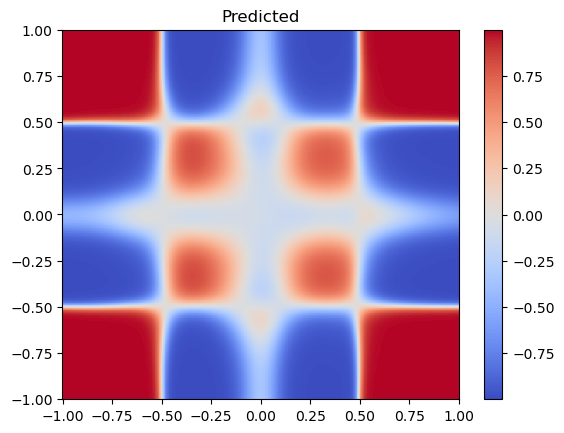

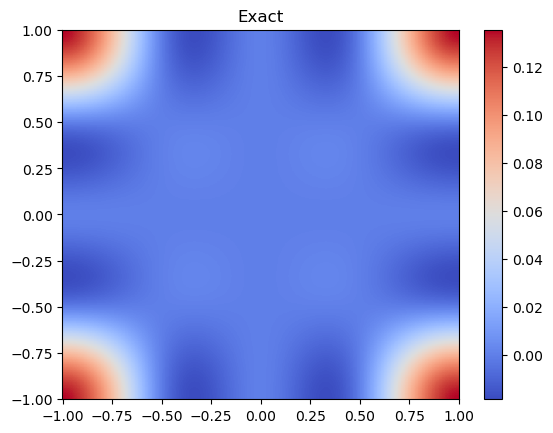

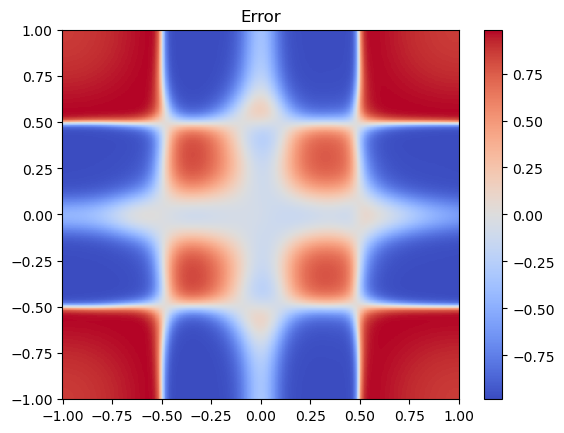

In [9]:
#%% Plotting Results
step = 1

xgrid = torch.linspace(-1, 1, N).resize(N,1)
ygrid = torch.linspace(-1, 1, N).resize(N,1)
xmesh, ymesh = np.meshgrid(xgrid.detach().numpy(),ygrid.detach().numpy())
ypred = upred[step-1]
ypred = ypred.detach().cpu()
ui = torch.exp(-torch.Tensor(xmesh)**2)*torch.cos(torch.pi*torch.Tensor(xmesh))*torch.exp(-torch.Tensor(ymesh)**2)*torch.cos(torch.pi*torch.Tensor(ymesh))*(torch.Tensor(xmesh**2)*torch.Tensor(ymesh)**2)

rel_l1norm = torch.sum(torch.sum(torch.abs(ypred-ui)))/torch.sum(torch.sum(torch.abs(ui)))
print("Relative L1 Norm: ", rel_l1norm)

rel_l2norm = torch.sum(torch.sum(torch.abs(ypred-ui)))/torch.sum(torch.sum(torch.abs(ui)))
print("Relative L1 Norm: ", rel_l1norm)

plt.figure()
plt.pcolor(xmesh, ymesh, ypred.detach().numpy(), cmap = 'coolwarm', label ='Predicted')
plt.colorbar()
plt.title('Predicted')

plt.figure()
plt.pcolor(xmesh, ymesh, ui.detach().numpy(), cmap = 'coolwarm', label ='Exact')
plt.colorbar()
plt.title('Exact')

plt.figure()
plt.pcolor(xmesh, ymesh, ypred.detach().numpy() - ui.detach().numpy(), cmap = 'coolwarm', label ='Error')
plt.colorbar()
plt.title('Error')

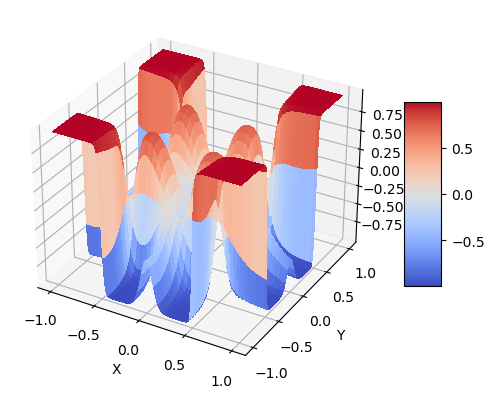

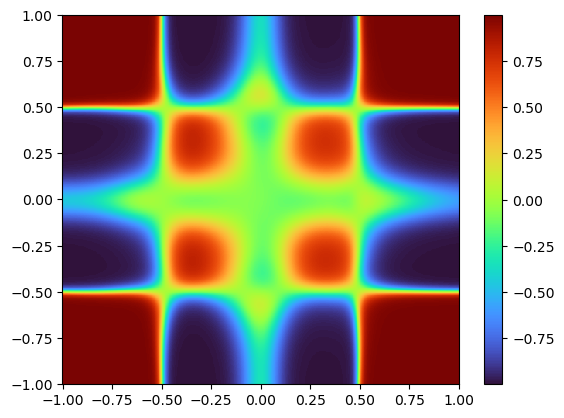

<Figure size 640x480 with 0 Axes>

In [10]:
#%% Plotting results for Deep Ritz Testing
step = 300

xgrid = torch.linspace(-1, 1, N).resize(N,1)
ygrid = torch.linspace(-1, 1, N).resize(N,1)
xmesh, ymesh = np.meshgrid(xgrid.detach().numpy(),ygrid.detach().numpy())
ypred = upred[step-1]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.figure()
plt.pcolor(xmesh, ymesh, ypred.detach().cpu().numpy(), cmap = 'turbo', label ='Predicted')
plt.colorbar()

plt.figure()
surf = ax.plot_surface(xmesh, ymesh, ypred.detach().cpu().numpy(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')

fig.colorbar(surf, shrink=0.5, aspect=5)


## Model Saving Utilities

In [11]:


path = '/pscratch/sd/v/vmattey/SPINN_AC_2D/results_data_aux'


import scipy.io
u_pred = []
for u in upred:
    u_pred.append(u.detach().cpu().numpy())

uu = {'upred':u_pred}
scipy.io.savemat(path+'upred_2D_IC2.mat',uu)
